In [1]:
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
def data_pipeline(
                data_path = 'data/stress.csv',
                target_cols = [
                            'TIPI1', 'TIPI2', 'TIPI3', 
                            'TIPI4', 'TIPI5', 'TIPI6', 
                            'TIPI7', 'TIPI8', 'TIPI9', 
                            'TIPI10'
                            ]
                ):

    df = pd.read_csv(
                    data_path,
                    sep="\t"
                    )
    df.dropna(inplace=True)
    output = df[target_cols]

    inputs = df.drop(target_cols, axis=1)
    cat_cols = inputs.select_dtypes(include=['object']).columns
    for col in cat_cols:
        del inputs[col]

    X = inputs.astype(float).values    
    Y = output.astype(float).values

    return X, Y
    

In [3]:
X, Y = data_pipeline()

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, Y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (22679, 160)
Y_train shape: (22679, 10)
X_test shape: (5670, 160)
Y_test shape: (5670, 10)


In [4]:
rfc = XGBClassifier(
                    n_estimators=80, 
                    random_state=42
                    )
mm_rfc = MultiOutputClassifier(rfc)
mm_rfc.fit(X, Y)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=80, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [5]:
with open('artifacts/model_stress.pkl', 'wb') as f:
    pickle.dump(mm_rfc, f)

In [6]:
P_train = mm_rfc.predict(X_train)
P_test = mm_rfc.predict(X_test)

In [7]:
target_cols = [
            'TIPI1', 'TIPI2', 'TIPI3', 
            'TIPI4', 'TIPI5', 'TIPI6', 
            'TIPI7', 'TIPI8', 'TIPI9', 
            'TIPI10'
            ]

In [8]:
for i in range(len(target_cols)):
    Yo_train = Y_train[:, i]
    Po_train = P_train[:, i]

    Yo_test = Y_test[:, i]
    Po_test = P_test[:, i]

    print(f"====================== {target_cols[i]} =======================")
    print("---------------------- Train CLS REPORT ----------------------")
    clf_report = classification_report(
                                    Yo_train,
                                    Po_train,
                                    target_names = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']
                                    )
    print(clf_report)

    print("---------------------- Test CLS REPORT ----------------------")
    clf_report = classification_report(
                                    Yo_test, 
                                    Po_test,
                                    target_names = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']
                                    )
    print(clf_report)

====================== TIPI1 =======================
---------------------- Train CLS REPORT ----------------------
              precision    recall  f1-score   support

          L1       1.00      1.00      1.00       281
          L2       0.95      0.91      0.93      3013
          L3       0.96      0.91      0.94      2902
          L4       0.99      0.89      0.94      2609
          L5       0.93      0.94      0.93      3636
          L6       0.87      0.98      0.92      5030
          L7       0.94      0.93      0.93      3724
          L8       1.00      0.93      0.97      1484

    accuracy                           0.93     22679
   macro avg       0.95      0.94      0.94     22679
weighted avg       0.94      0.93      0.93     22679

---------------------- Test CLS REPORT ----------------------
              precision    recall  f1-score   support

          L1       1.00      1.00      1.00        53
          L2       0.94      0.91      0.92       748
        

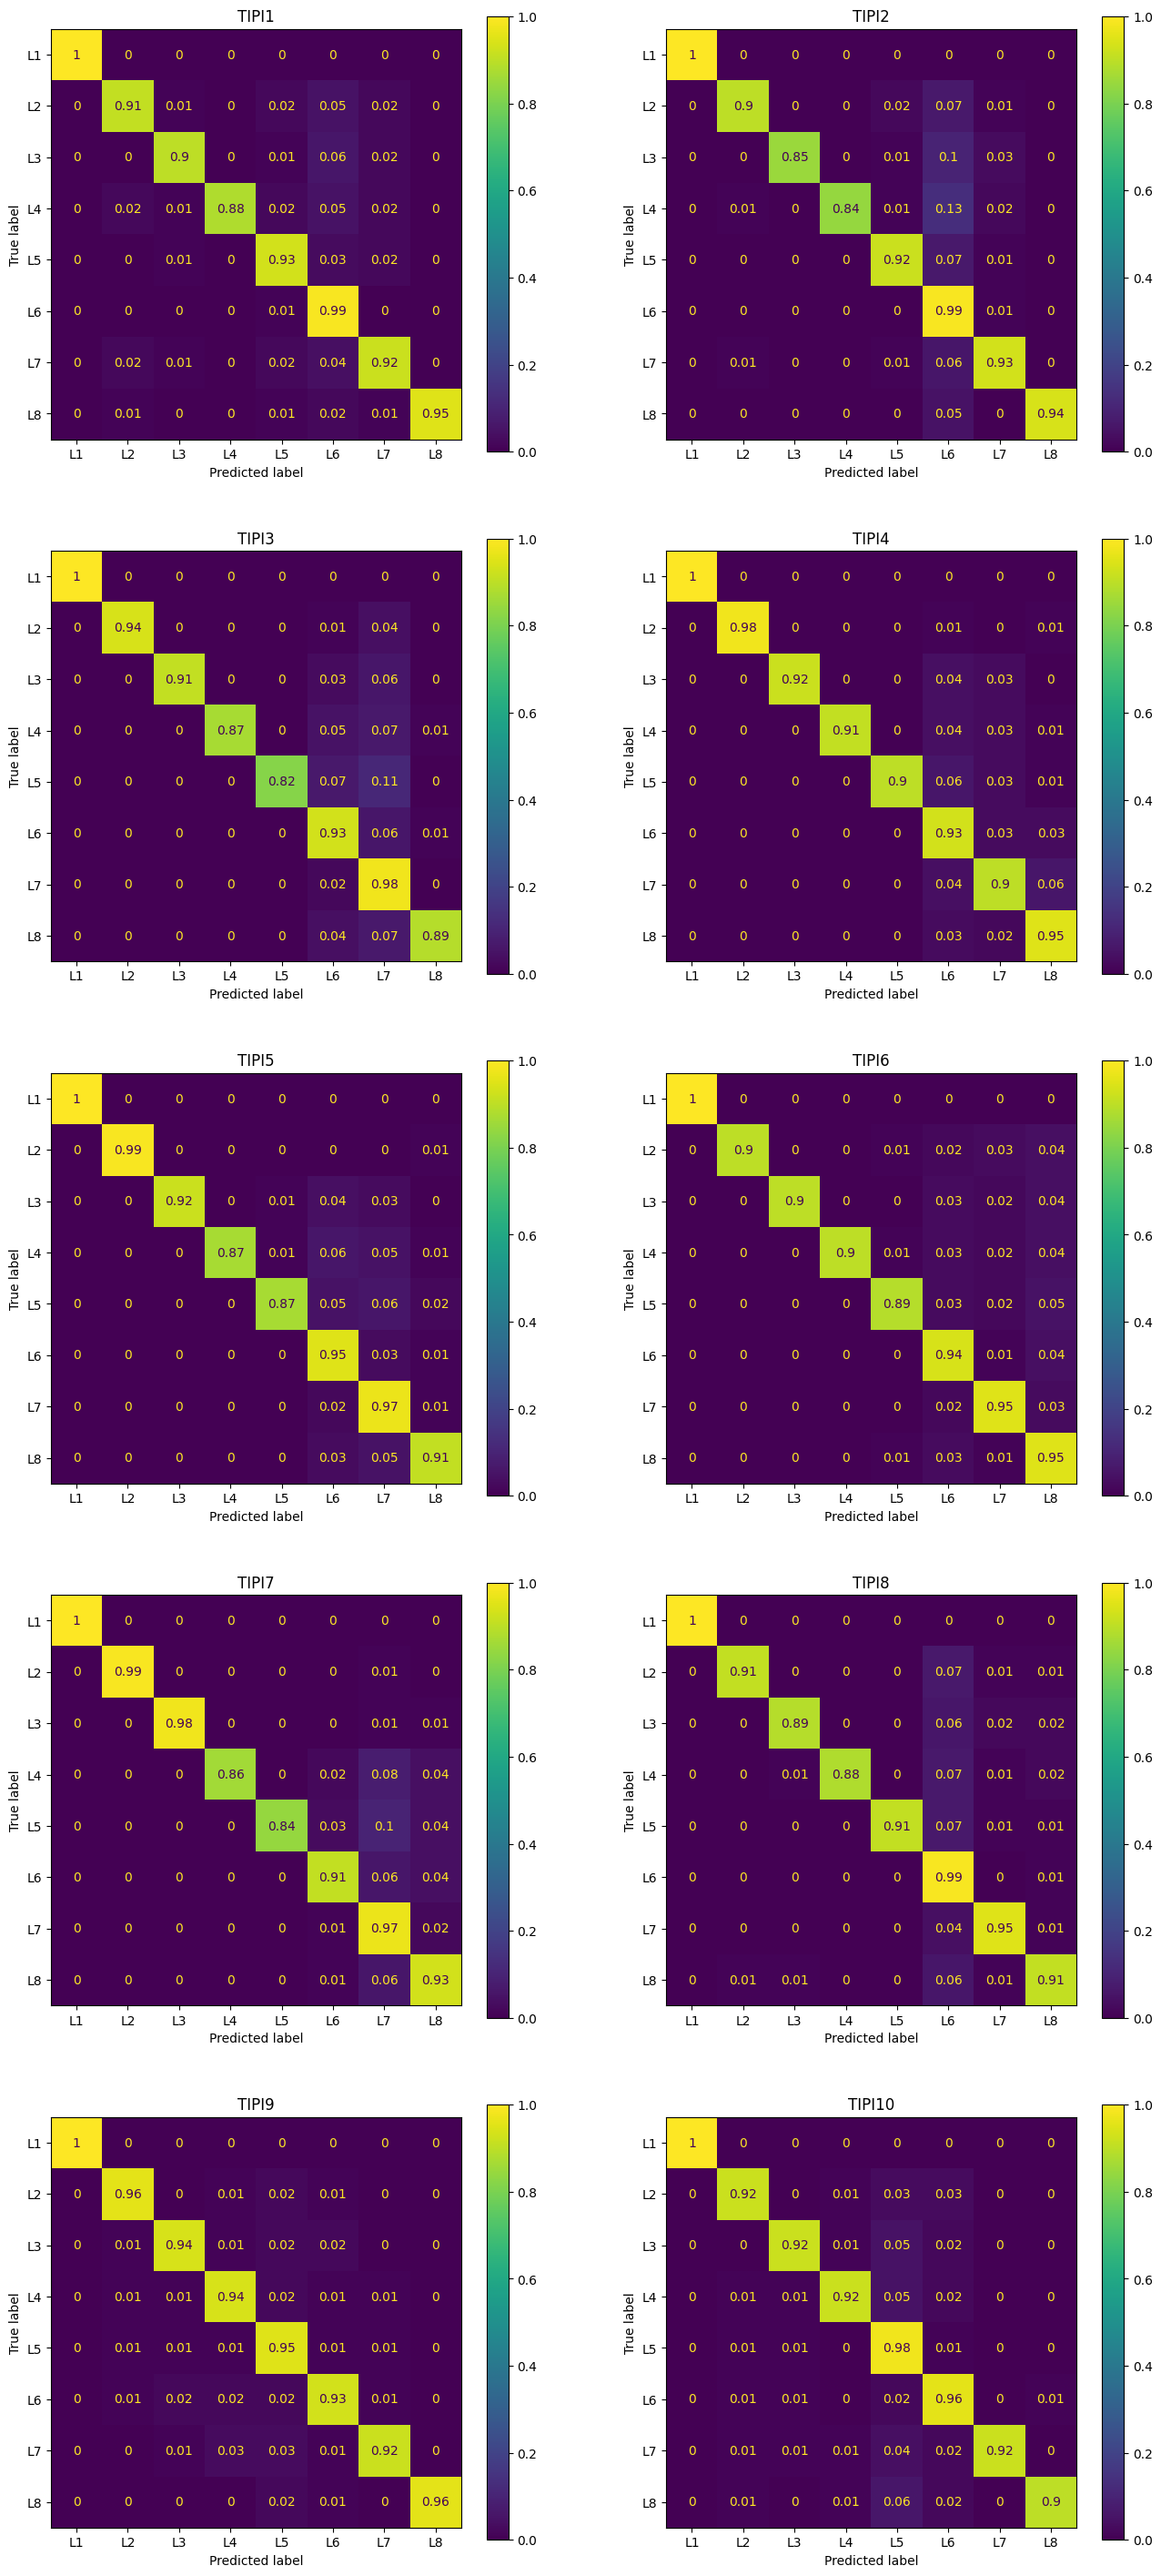

In [9]:
plt.figure(figsize=(16, 36))
for i in range(len(target_cols)):
    Yo_test = Y_test[:, i]
    Po_test = P_test[:, i]
    cm = confusion_matrix(Yo_test, Po_test)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.round(cm, 2)
    disp = ConfusionMatrixDisplay(
                                confusion_matrix=cm,
                                display_labels=['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']
                                )
    disp.plot(ax=plt.subplot(5, 2, i+1))
    plt.title(target_cols[i])

### inference

In [10]:
sample_json = {"Q1A":2,"Q1I":23,"Q1E":5081,"Q2A":3,"Q2I":11,"Q2E":6837,"Q3A":2,"Q3I":37,"Q3E":5521,"Q4A":1,"Q4I":27,"Q4E":4556,"Q5A":3,"Q5I":28,"Q5E":3269,"Q6A":3,"Q6I":26,"Q6E":3231,"Q7A":4,"Q7I":2,"Q7E":7138,"Q8A":2,"Q8I":19,"Q8E":3079,"Q9A":3,"Q9I":31,"Q9E":9650,"Q10A":3,"Q10I":17,"Q10E":4179,"Q11A":2,"Q11I":5,"Q11E":5928,"Q12A":1,"Q12I":21,"Q12E":2838,"Q13A":1,"Q13I":20,"Q13E":2560,"Q14A":4,"Q14I":29,"Q14E":5139,"Q15A":2,"Q15I":22,"Q15E":3597,"Q16A":2,"Q16I":35,"Q16E":3336,"Q17A":3,"Q17I":10,"Q17E":4506,"Q18A":1,"Q18I":14,"Q18E":2695,"Q19A":1,"Q19I":25,"Q19E":8128,"Q20A":2,"Q20I":15,"Q20E":3125,"Q21A":1,"Q21I":6,"Q21E":4061,"Q22A":1,"Q22I":40,"Q22E":4272,"Q23A":1,"Q23I":12,"Q23E":4029,"Q24A":1,"Q24I":9,"Q24E":5630,"Q25A":1,"Q25I":18,"Q25E":30631,"Q26A":2,"Q26I":24,"Q26E":9870,"Q27A":4,"Q27I":4,"Q27E":2411,"Q28A":1,"Q28I":16,"Q28E":9478,"Q29A":3,"Q29I":1,"Q29E":7618,"Q30A":3,"Q30I":32,"Q30E":12639,"Q31A":3,"Q31I":34,"Q31E":5378,"Q32A":1,"Q32I":41,"Q32E":8923,"Q33A":2,"Q33I":38,"Q33E":2977,"Q34A":4,"Q34I":3,"Q34E":5620,"Q35A":1,"Q35I":7,"Q35E":16760,"Q36A":1,"Q36I":8,"Q36E":6427,"Q37A":2,"Q37I":39,"Q37E":3760,"Q38A":1,"Q38I":13,"Q38E":4112,"Q39A":3,"Q39I":42,"Q39E":2769,"Q40A":4,"Q40I":33,"Q40E":4432,"Q41A":4,"Q41I":30,"Q41E":3643,"Q42A":2,"Q42I":36,"Q42E":3698,"source":2,"introelapse":3,"testelapse":261,"surveyelapse":336,"VCL1":1,"VCL2":0,"VCL3":0,"VCL4":1,"VCL5":1,"VCL6":0,"VCL7":0,"VCL8":0,"VCL9":0,"VCL10":1,"VCL11":0,"VCL12":0,"VCL13":0,"VCL14":1,"VCL15":1,"VCL16":1,"education":1,"urban":3,"gender":2,"engnat":1,"age":13,"screensize":2,"uniquenetworklocation":1,"hand":2,"religion":4,"orientation":5,"race":70,"voted":2,"married":1,"familysize":5}

In [11]:
import yaml, os
from llama_index.core.llms import (
                                ChatMessage,
                                MessageRole
                                )
from llama_index.llms.groq import Groq
from llama_index.core import ChatPromptTemplate
from llama_index.core import Settings

C:\Users\isuru\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
with open('artifacts/model_stress.pkl', 'rb') as f:
    model_stress = pickle.load(f)

In [25]:
with open('secrets.yaml') as f:
    secrets = yaml.load(f, Loader=yaml.FullLoader)

os.environ["GROQ_API_KEY"] = secrets['GROQ_API_KEY']
completion_llm = Groq(
                    model="llama3-70b-8192", 
                    api_key=os.environ["GROQ_API_KEY"],
                    temperature=0.0
                    )
Settings.llm = completion_llm

STRESS_PROMPT = """
You are a professional fitness trainer with experience in mental health. You have a client who is experiencing stress.

here is the recovery plan you provided to the client:
{recoveryplan}

below are the comments of the client:
{comments}

based on the recovery plan and comments, modify the recovery plan and provide the new recovery plan to the client.
"""

stress_template = ChatPromptTemplate(
                                message_templates=[
                                                ChatMessage(
                                                            role=MessageRole.SYSTEM, 
                                                            content=STRESS_PROMPT
                                                            )
                                                ]
                                )

In [26]:
def inference_stress(
                    sample_json,
                    comments = None,
                    plan_path = "data/plans.xlsx"
                    ):
    sample_df = pd.DataFrame([sample_json])
    sample_df = sample_df.astype(float)
    sample_X = sample_df.values
    sample_Y = model_stress.predict(sample_X)
    total_score = np.sum(sample_Y).squeeze()

    df_plans = pd.read_excel(plan_path)
    if total_score <= 10:
        score_range = "0-10"
    elif total_score <= 20:
        score_range = "11-20"
    elif total_score <= 30:
        score_range = "21-30"
    elif total_score <= 40:
        score_range = "31-40"
    elif total_score <= 50:
        score_range = "41-50"
    elif total_score <= 60:
        score_range = "51-60"
    elif total_score <= 70:
        score_range = "61-70"
    recovery_plan = df_plans[df_plans["Score Range"] == score_range]["Recovery Plan"].values[0]
    if comments is None:
        return total_score, recovery_plan
    
    fmt_messages = stress_template.format(
                                    recoveryplan=recovery_plan,
                                    comments=comments
                                    )
    chat_response = completion_llm.complete(fmt_messages)
    recovery_plan_updated = chat_response.text
    return total_score, recovery_plan_updated



In [27]:
total_score, recovery_plan = inference_stress(
                                                sample_json,
                                                comments="I can't do aerobic exercises"
                                                )
print(f"Total Stress Score: {total_score}")
print(f"Recovery Plan: {recovery_plan}")

Total Stress Score: 40
Recovery Plan: I understand that aerobic exercises may not be feasible for you right now. Let's modify the recovery plan to accommodate your needs.

**Modified Recovery Plan:**

**Plan 4.1: Gentle Stress Relief through Yoga and Journaling**

Instead of aerobic exercises, we'll focus on gentle yoga exercises that can help reduce stress and anxiety. Yoga has been shown to have a positive impact on mental health, and it can be modified to suit your fitness level.

**Yoga Component:**

* Start with 10-15 minute gentle yoga sessions, 2-3 times a week
* Focus on gentle flows, deep breathing, and relaxation techniques
* We can work together to create a customized yoga routine that suits your needs and comfort level

**Journaling Component:**

* Continue with the journaling exercise as previously planned
* Set aside 10-15 minutes each day to write down your thoughts, feelings, and reflections
* Focus on expressing your emotions, identifying patterns, and practicing grati